In [32]:
from datetime import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.optimize import minimize
import math
import warnings
warnings.filterwarnings('ignore')

In [35]:
# Some Functions needed in the project

# The function to get the first position of one element (el) in a sequence (s)
def find(s, el):
    for i in range(len(s)):
        if s[i] == el: 
            return i+1
    return None


# The following functions need a specified dataframe
# where the columns are target_end_date, value and model
# target_end_date is the forecasted date (e.g. 2022-01-01, datetime)
# value is the forecast (here is the weekly incident deaths (e.g. 10298.0 float)
# model is the name of the model, including the real deaths (e.g. CU_nochange, string)

#This is the function return the real hitting time given a dataframe
def RealHitTime(boundary,DF):
    r = DF.loc["Real"] # get the row which saves the real data 
    
    # len(DF.columns) is just L
    hit = len(DF.columns)+1 # if no crossing, return L+1
    for i in r:
        # once hitting, return the value and find its position in the row
        if i >= boundary:
            hit = find(r,i)
            break #stop search as we just need the first hitting time
            
    return hit

# Calculate the EAH (Ensemble Average path Hitting time) 
def EAH(boundary,DF):
    length = len(DF)-1 # number of models, -1 as real data also in dataframe
    DFF = DF.loc[DF.index != "Real"] # Here delete the real data
    mean = DFF[DFF.columns].mean() # For each time, calculate the mean
    
    #The following is just like the design of RealHitTime(boundary,DF)
    hittime = len(mean)+1
    for j in mean:
        if j >= boundary:
            hittime = find(mean,j)
            break
    return hittime

# Calculate the HAI (Hitting time Average after Imputation) 
def HAI(boundary,DF):
    DDFF = DF.loc[DF.index != "Real"]
    num = len(DDFF.index)
    arr = [] # Create a container of the hitting time of each models
    #For each models, find its hitting time
    for i in DDFF.index:
        dd = DDFF.loc[i]
        hit = len(DDFF.columns)+1
        for j in dd:
            if j>= boundary:
                hit = find(dd,j)
                break
        arr.append(hit)
    return sum(arr)/num # Take average

# Calculate the EMH (Ensemble Median path Hitting time) 
def EMH(boundary,DF):
    length = len(DF)-1
    DFF = DF.loc[DF.index != "Real"]
    m = DFF[DFF.columns].median()
    hittime = len(m)+1
    for j in m:
        if j >= boundary:
            hittime = find(m,j)
            break
    return hittime

# Calculate the HAD (Hitting time Average after Deletion) 
def HAD(boundary,DF):
    DFF = DF.loc[DF.index != "Real"]
    MAX = DFF.max(axis = 1)
    DFF["MAX"] = DFF.max(axis = 1) 
    DDFF = DFF.loc[DFF["MAX"]>=boundary]
    if len(DDFF) == 0:
        return len(DF.columns)+1
    
    else:
        num = len(DDFF.index)
        arr = []
        for i in DDFF.index:
            dd = DDFF.loc[i]
            for j in dd:
                if j >= boundary:
                    hit = find(dd,j)
                    arr.append(hit)
                    break
        return sum(arr)/num
    
# Calculate the HMD (Hitting time Median after Deletion) 
def HMD(boundary,DF):
    DFF = DF.loc[DF.index != "Real"]
    MAX = DFF.max(axis = 1)
    DFF["MAX"] = DFF.max(axis = 1) 
    DDFF = DFF.loc[DFF["MAX"]>=boundary]
    if len(DDFF) == 0:
        return len(DF.columns)+1
    
    else:
        num = len(DDFF.index)
        arr = []
        for i in DDFF.index:
            dd = DDFF.loc[i]
            for j in dd:
                if j >= boundary:
                    hit = find(dd,j)
                    arr.append(hit)
                    break
        return np.median(np.array(arr))

# Calculate the HMI (Hitting time Median after Imputation) 
def HMI(boundary,DF):
    DDFF = DF.loc[DF.index != "Real"]
    num = len(DDFF.index)
    arr = []
    for i in DDFF.index:
        dd = DDFF.loc[i]
        hit = len(DDFF.columns)+1
        for j in dd:
            if j >= boundary:
                hit = find(dd,j)
                break
        arr.append(hit)
    return np.median(np.array(arr))

In [39]:
# The time we care
# the start time (a)
a = pd.to_datetime('2020-03-14')
b = pd.to_datetime('2020-03-21')

# a length of one week (week)
week = b-a

# the end time (c), in fact is c-week
c = pd.to_datetime('2022-05-28')

# a length of one day (day)
day = pd.to_datetime('2020-03-21')-pd.to_datetime('2020-03-20')
i=a


dates = [i]
dates_string = [str(i)[:10]] # get the year-month-date of i
while i != c:
    i = i+week
    dates.append(i)
    dates_string.append(str(i)[:10])
    
# The real weekly incident deaths got form covid19hub
real_death = [43,421,2536,8174,14617,15168,15494,13367,12274,9997,8465,6545,5902,5094,4191,
     3867,3694,5291,5559,6512,7977,7283,7124,6086,6331,5830,5095,5410,5310,4801,5027,5238,
     5806,5947,7270,7936,10893,10912,15812,17595,19193,16180,19047,22390,23543,21981,21687,
     20903,17425,13192,13876,12016,8735,7119,7016,5814,6909,5056,5051,4922,4739,4077,3927,
     4516,3294,2545,2098,2110,1685,1594,1919,1934,2577,3667,4795,7424,9394,11451,12402,14448,14693,
     14013,11928,11772,11812,9355,8560,8533,8068,5738,11788,9080,9308,8193,9314,12224,14107,
     15361,18078,17725,16961,15528,12256,10071,8655,6972,5485,4683,3553,3104,2643,2419,3870,
     1819,2345,2509]

# A dataframe
Realdata=pd.DataFrame(index = dates_string)
Realdata["Value"] = real_death
Realdata["TimeStamp"] = dates
Realdata["TimeString"] = dates_string

# WhatWeWantToSee gives the time for further call
WhatWeWantToSee = Realdata.loc["2020-05-30":]
WhatWeWantToSee = WhatWeWantToSee[["TimeStamp","TimeString"]]

In [40]:
# All models we consider
ModelName = ["AIpert-pwllnod","Auquan-SEIR","BPagano-RtDriven","CDDEP-SEIR_MCMC","CEID-Walk","CMU-TimeSeries","CU-nochange","CUB_PopCouncil-SLSTM","CUBoulder-COVIDLSTM","CWRU-COVID_19Predict","Caltech-CS156","Columbia_UNC-SurvCon","Covid19Sim-Simulator",
            "CovidActNow-SEIR_CAN","CovidAnalytics-DELPHI","DDS-NBDS","FAIR-NRAR","FDANIHASU-Sweight","FRBSF_Wilson-Econometric","GT-DeepCOVID","GT_CHHS-COVID19","Geneva-DetGrowth","Google_Harvard-CPF","HKUST-DNN","IBF-TimeSeries","IEM_MED-CovidProject",
             "IHME-CurveFit","IQVIA_ACOE-STAN","ISUandPKU-vSEIdR","IUPUI-HkPrMobiDyR","IowaStateLW-STEM","JBUD-HMXK","JCB-PRM","JHUAPL-Bucky","JHUAPL-Gecko","JHUAPL-SLPHospEns","JHU_CSSE-DECOM","JHU_IDD-CovidSP","JHU_UNC_GAS-StatMechPool","Karlen-pypm","LANL-GrowthRate",
            "LNQ-ens1","LUcompUncertLab-VAR_3streams","LosAlamos_NAU-CModel_SDVaxVar","MIT-Cassandra","MITCovAlliance-SIR","MIT_CritData-GBCF","MIT_ISOLAT-Mixtures","MOBS-GLEAM_COVID","MSRA-DeepST","MUNI-ARIMA","MUNI-VAR","Microsoft-DeepSTIA","NCSU-COVSIM",
            "NotreDame-FRED","NotreDame-mobility","OliverWyman-Navigator","OneQuietNight-ML","PSI-DICE","PSI-DRAFT","PandemicCentral-COVIDForest","PandemicCentral-USCounty","QJHong-Encounter","Quantori-Multiagents","RPI_UW-Mob_Collision","RobertWalraven-ESG",
            "SDSC_ISG-TrendModel","STH-3PU","SWC-TerminusCM","SigSci-TS","SteveMcConnell-CovidComplete","TTU-squider","UA-EpiCovDA","UCF-AEM","UCLA-SuEIR","UCM_MESALab-FoGSEIR","UCSB-ACTS","UCSD_NEU-DeepGLEAM","UChicagoCHATTOPADHYAY-UnIT","UMass-ExpertCrowd",
            "UMass-MechBayes","UMass-sarix","UMass-trends_ensemble","UMich-RidgeTfReg","USACE-ERDC_SEIR","USC-SI_kJalpha","USC-SI_kJalpha_RF","USF-STPM","UT-Mobility","UT-Osiris","UT_GISAG-SPDM","UVA-Ensemble","UpstateSU-GRU","Wadhwani_AI-BayesOpt","WalmartLabsML-LogForecasting",
            "YYG-ParamSearch","Yu_Group-CLEP","prolix-euclidean"]

In [ ]:
# DO NOT RUN IT PLEASE, UNLESS YOU WANT TO CHECK ITS CORRECTNESS.
# This code is time-consuming and may take over 1 over to run. 
# SO YOU'D BETTER NOT NOT RUN IT!!!

# Generate the dataframe of the raw data
RawData = pd.DataFrame(columns=[["target_end_date","value","model","Start"]])
RawData.columns = ["target_end_date","value","model","Start"]
for t in WhatWeWantToSee.index: 
    if t == '2022-04-30':
        break
    time = WhatWeWantToSee.loc[t]['TimeStamp']
    timestring = WhatWeWantToSee.loc[t]['TimeString']
    endtime = time + week+week+week+week
    Model_in_This_Week  = pd.DataFrame()
    for i in ModelName:
        url1 = 'https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-processed/'+i+'/'+str(time+day)[:10]+'-'+i+'.csv'
        url2 = 'https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-processed/'+i+'/'+str(time+day+day)[:10]+'-'+i+'.csv'
        try:
            df = pd.read_csv(url1)
            rt = df.loc[df['type'] == "point"].loc[df['location'] == "US"].loc[df['target'].isin(["1 wk ahead inc death","2 wk ahead inc death","3 wk ahead inc death","4 wk ahead inc death"])];rt.reset_index(drop = True, inplace = True);
            if len(rt)==4:
                model = rt[["target_end_date","value"]];model["model"] = i;Model_in_This_Week = pd.concat([Model_in_This_Week,model])
            #print(i)
        except :
            try:
                df = pd.read_csv(url2)
                rt = df.loc[df['type'] == "point"].loc[df['location']== "US"].loc[df['target'].isin(["1 wk ahead inc death","2 wk ahead inc death","3 wk ahead inc death","4 wk ahead inc death"])];rt.reset_index(drop = True, inplace = True);
                if len(rt)==4:
                    model = rt[["target_end_date","value"]];model["model"] = i;Model_in_This_Week = pd.concat([Model_in_This_Week,model])
                #print(i)
            except :
                print('',end='',flush=True)


    Models = Model_in_This_Week;Real_Model = Models[:4].copy();Real_Model["model"] = "Real"
    Real_5week = np.array(Realdata.loc[timestring:str(endtime)[:10]]["Value"])
    Real_4week = Real_5week[1:]
    Real_Model["value"] = Real_4week
    Model_and_Real = pd.concat([Real_Model,Models]);
    Model_and_Real.reset_index(drop = True, inplace = True);
    Model_and_Real["target_end_date"] = pd.to_datetime(Model_and_Real["target_end_date"]);
    Model_and_Real["Start"] = t
    RawData = pd.concat([RawData,Model_and_Real])
    print(timestring+" ",end='',flush=True)
print("Finished")  
RawData.reset_index(drop = True, inplace = True)
RawData.to_csv("Raw.csv",index=True,header=True)

Calculate MSE, MSE_{TN^C} and correlation

In [41]:
Data = pd.read_csv("Raw.csv")
Data = Data.T.iloc[1:].T

# Here the forecasts given by OliverWyman-Navigator on 2021-06-12 and 2021-06-19 are nan and we delete it
Data = Data.drop( Data[(Data["model"] == "OliverWyman-Navigator") & (Data["Start"] == "2021-06-12")].index )
Data = Data.drop( Data[(Data["model"] == "OliverWyman-Navigator") & (Data["Start"] == "2021-06-19")].index )

In [42]:
Data

,target_end_date,value,model,Start
0,2020-06-06,5902.0,Real,2020-05-30
1,2020-06-13,5094.0,Real,2020-05-30
2,2020-06-20,4191.0,Real,2020-05-30
3,2020-06-27,3867.0,Real,2020-05-30
4,2020-06-06,3681.099106,Covid19Sim-Simulator,2020-05-30
...,...,...,...,...
12319,2022-05-21,5483.058615,USC-SI_kJalpha,2022-04-23
12320,2022-04-30,2641.0,prolix-euclidean,2022-04-23
12321,2022-05-07,2785.0,prolix-euclidean,2022-04-23
12322,2022-05-14,2833.0,prolix-euclidean,2022-04-23


The main body of the project

In [43]:
# Calculate the Confusion Matrix of one estimator and the real hitting time
# which return the type(TN, TP, FN, FP), MSE and boundary
def ConfusionMSE(estimator,realhittingtime,L,boundary):
    es = estimator;rht = realhittingtime
    rtn = pd.DataFrame(index = [0],columns = [["Type","MSE","Boundary","Estimate","Real"]])
    rtn["Boundary"] = boundary
    rtn["Estimate"] = estimator
    rtn["Real"] = realhittingtime
    SE = (es-rht)**2
    if es > L and rht > L:
        rtn["Type"] = ["TN"];rtn["MSE"]=0
    elif es > L and rht <= L:
        rtn["Type"] = ["FN"];rtn["MSE"]=SE
    elif es <= L and rht <= L:
        rtn["Type"] = ["TP"];rtn["MSE"]=SE
    else:
        rtn["Type"] = ["FP"];rtn["MSE"]=SE
    return rtn

In [44]:
# a set of boundary we want to test
bdry = np.arange(1000,20200,200)

EAH_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])
EMH_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])
HAI_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])
HAD_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])
HMI_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])
HMD_ = pd.DataFrame(columns = [["Type","MSE","Boundary","Estimate","Real"]])

# Same operation
for boundary in bdry:
    print(boundary,end='',flush=True)
    for i in WhatWeWantToSee["TimeString"]:
        WeekData = Data.loc[Data["Start"] == i]
        WeekData.reset_index(drop = True, inplace = True);
        WeekData["target_end_date"] = pd.to_datetime(WeekData["target_end_date"]);
        md = pd.unique(WeekData["model"]);
        date = pd.unique(WeekData["target_end_date"]);
        df = pd.DataFrame(index = md,columns = date)
        for j in range(len(WeekData)):
            n = WeekData.iloc[j];df[n[0]][n[2]] = n[1]

        EAH_ = pd.concat([EAH_,ConfusionMSE(EAH(boundary,df),RealHitTime(boundary,df),4,boundary)]);EAH_.reset_index(drop = True, inplace = True);
        EMH_ = pd.concat([EMH_, ConfusionMSE(EMH(boundary,df), RealHitTime(boundary,df),4,boundary)]);EMH_.reset_index(drop = True, inplace = True);
        HAI_ = pd.concat([HAI_, ConfusionMSE(HAI(boundary,df), RealHitTime(boundary,df),4,boundary)]);HAI_.reset_index(drop = True, inplace = True);
        HAD_ = pd.concat([HAD_, ConfusionMSE(HAD(boundary,df), RealHitTime(boundary,df),4,boundary)]);HAD_.reset_index(drop = True, inplace = True);
        HMI_ = pd.concat([HMI_, ConfusionMSE(HMI(boundary,df), RealHitTime(boundary,df),4,boundary)]);HMI_.reset_index(drop = True, inplace = True);
        HMD_ = pd.concat([HMD_, ConfusionMSE(HMD(boundary,df), RealHitTime(boundary,df),4,boundary)]);HMD_.reset_index(drop = True, inplace = True);
        if i == '2022-04-23':
            break
print("finish")

100012001400160018002000220024002600280030003200340036003800400042004400460048005000520054005600580060006200640066006800700072007400760078008000820084008600880090009200940096009800100001020010400106001080011000112001140011600118001200012200124001260012800130001320013400136001380014000142001440014600148001500015200154001560015800160001620016400166001680017000172001740017600178001800018200184001860018800190001920019400196001980020000finish


In [46]:
dictionary = {"EAH":EAH_,'EMH':EMH_,'HAI':HAI_,'HAD':HAD_,'HMI':HMI_,'HMD':HMD_}

In [82]:
for estimator in dictionary:
    # download the cvss
    dictionary[estimator].to_csv(estimator+"WT.csv")

In [83]:
# Get the data frame (prob) of the probability of each situation in each boundary level, of 6 estimators
# Get the MSE decomposition (MSE_deco) of each situation in each boundary level, of 6 estimators
prob = pd.DataFrame(columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])
MSE_deco = pd.DataFrame(columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])

In [84]:
# Get the correlation of our eastimators and the real hitting time
esti = ["EAH","EMH","HAI","HAD","HMI","HMD"]
bdry = np.arange(1000,20200,200)
Cor_WT = pd.DataFrame(columns = esti)
for estimator in dictionary:
    dataOfThisEstimator = dictionary[estimator]
    dataOfThisEstimator.columns = ["Type","MSE","Boundary","Estimate","Real"]
    columnOfThisEstimator = []
    for b in bdry:
        dataForThisBoundary = dataOfThisEstimator.loc[dataOfThisEstimator["Boundary"]==b][["Estimate","Real"]]
        numericData = dataForThisBoundary.astype("float")
        add = numericData.corr()["Real"][0]
        if np.isnan(add):
            add = 0
        columnOfThisEstimator.append(add)
    Cor_WT[estimator] = columnOfThisEstimator

In [85]:
# Get the MSE of our eastimators
MSE_WT = pd.DataFrame(columns = ["EAH","EMH","HAI","HAD","HMI","HMD"])
for e in dictionary:
    st = dictionary[e]
    st.columns = ["Type","MSE","Boundary","Estimate","Real"]
    output = st.groupby(["Boundary"]).mean()
    MSE_WT[e] = output["MSE"]

In [86]:
# Get the $ MSE_{TN^C} $ of our eastimators
esti = ["EAH","EMH","HAI","HAD","HMI","HMD"]
bdry = np.arange(1000,20200,200)
MSE_TNC_WT = pd.DataFrame(columns = esti)
for e in esti:
    dataOfThisEstimator = pd.read_csv(e+"WT.csv")
    dataOfThisEstimator = dataOfThisEstimator[["Type","MSE","Boundary"]]
    columnOfThisEstimator = []
    for b in bdry:
        en = dataOfThisEstimator.loc[dataOfThisEstimator["Boundary"] == b]
        TNs = len(en.loc[en["Type"] == "TN"])
        add = en["MSE"].mean()*100/(100-TNs)
        columnOfThisEstimator.append(add)
    MSE_TNC_WT[e] = columnOfThisEstimator
#MSE_TNC_WT

In [87]:
MSE_TNC_WT.to_csv("MSE_TNC_WT.csv")
MSE_WT.to_csv("MSE_WT.csv")
Cor_WT.to_csv("Cor_WT.csv")

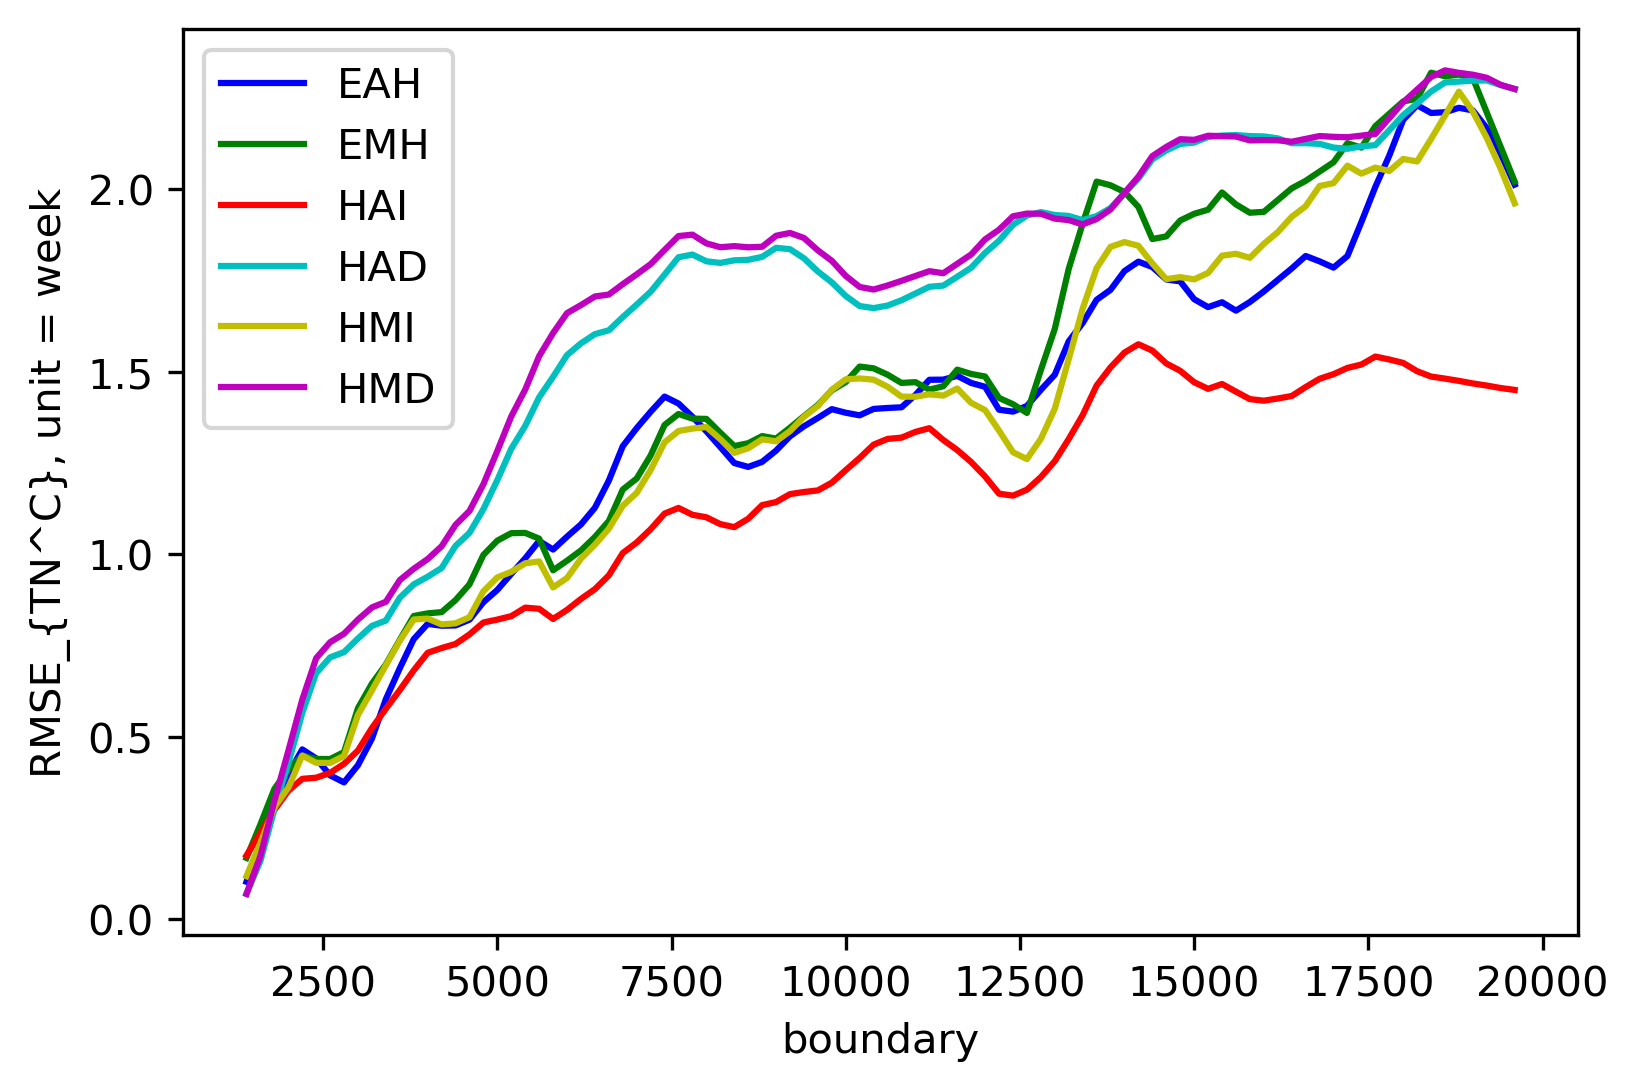

<Figure size 432x288 with 0 Axes>

In [88]:
# Visualization of Correlation Comparsion

# move average function designed by Haolin Zou
def np_move_avg(a,n,mode="valid"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

bdry = np.arange(1000,20200,200)
col_seq = ['b','g','r','c','y','m']
names = ['EAH','EMH', 'HAI','HAD','HMI','HMD']
plt.figure(figsize = (6,4),dpi=300)

for i in range(6):
    plt.plot(bdry[2:94],
             np_move_avg(np.sqrt(np.array(MSE_TNC_WT[names[i]])),5,mode="valid"),
             color=col_seq[i],
             label=names[i])
    
plt.xlabel('boundary')
plt.ylabel('RMSE_{TN^C}, unit = week')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("COVID RMSE_TNC.png",dpi=300)

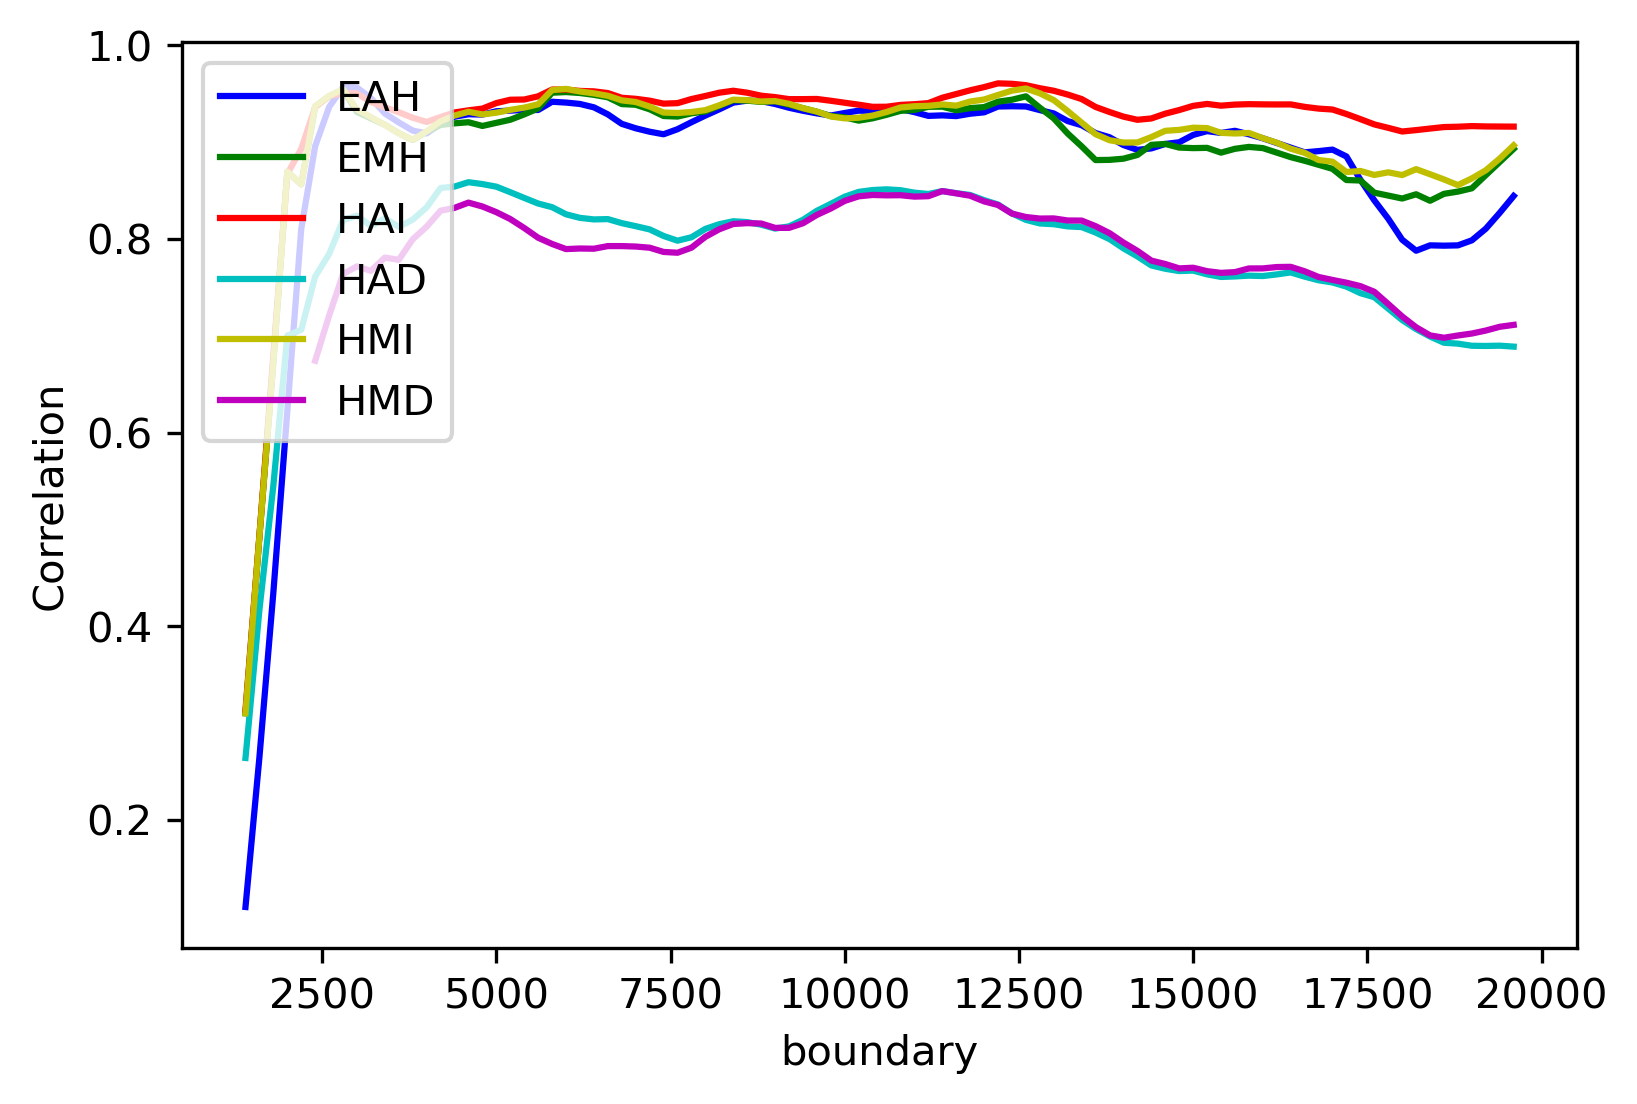

<Figure size 432x288 with 0 Axes>

In [89]:
# Visualization of Correlation Comparsion
plt.figure(figsize = (6,4),dpi=300)
for i in range(6):
    plt.plot(bdry[2:94],
             np_move_avg(np.sqrt(np.array(Cor_WT[names[i]])),5,mode="valid"),
             color=col_seq[i],
             label=names[i])
    
plt.xlabel('boundary')
plt.ylabel('Correlation')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("COVID Correlation.png",dpi=300)

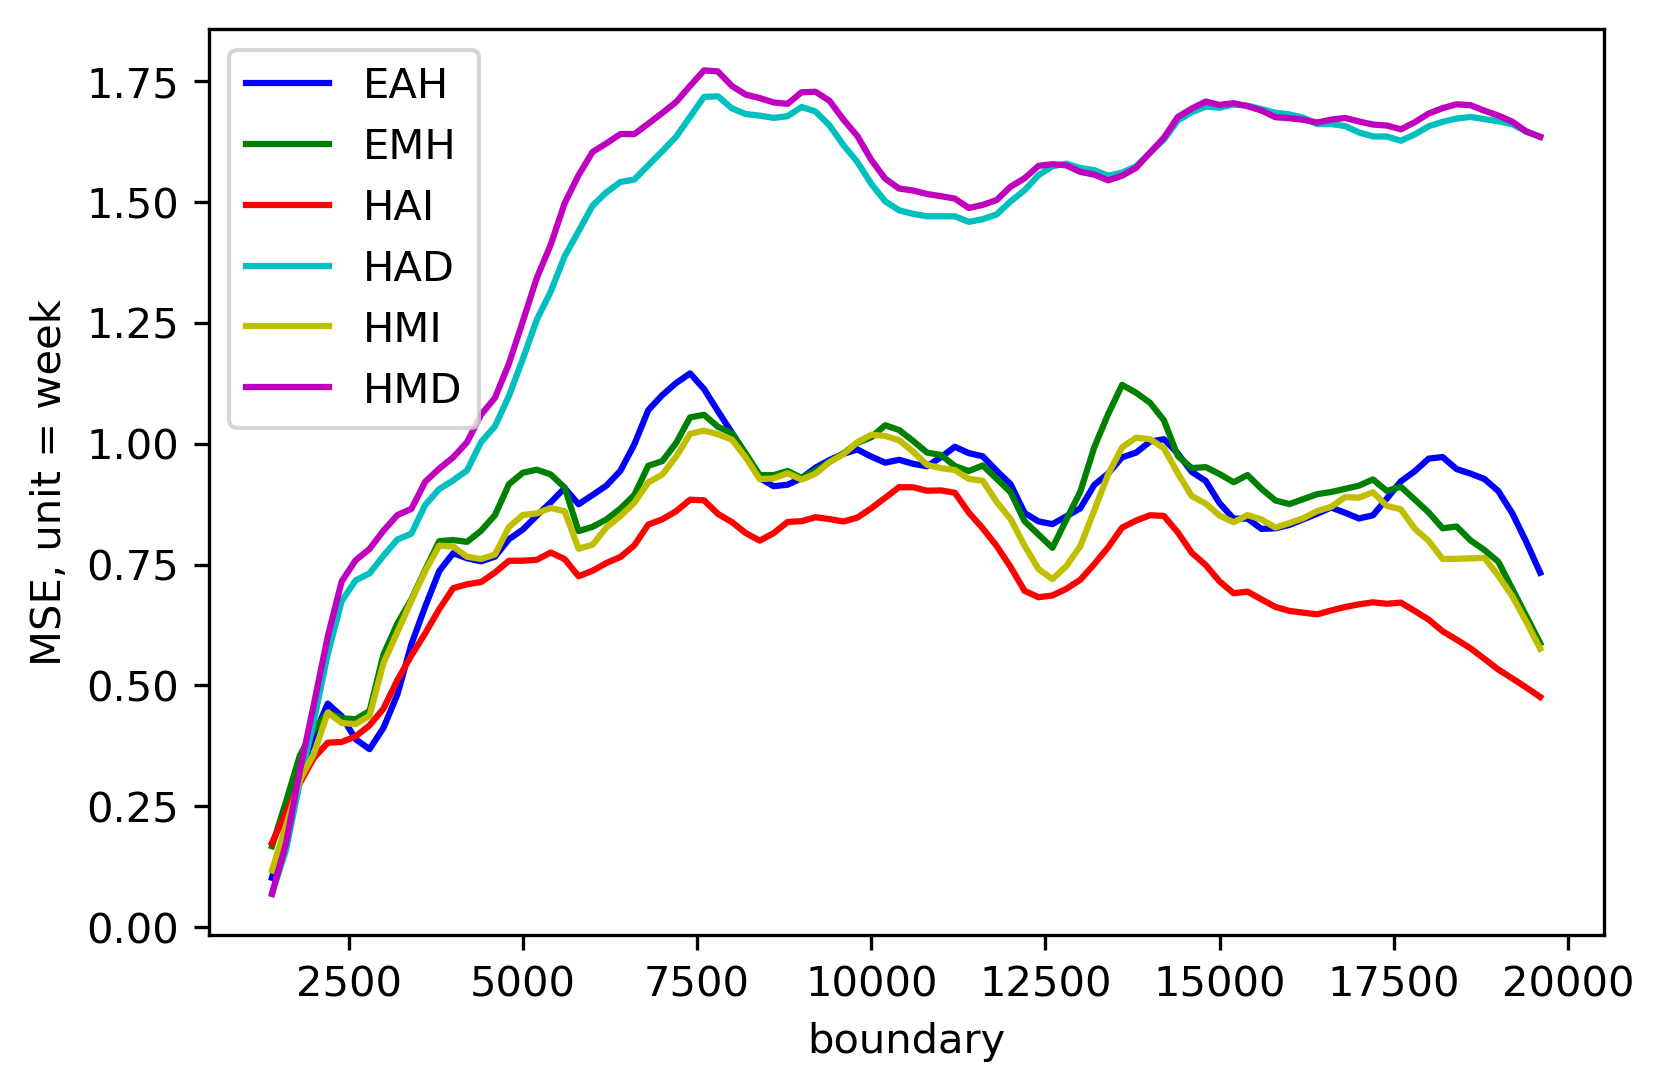

<Figure size 432x288 with 0 Axes>

In [60]:
# Visualization of MSE Comparsion
plt.figure(figsize = (6,4),dpi=300)
for i in range(6):
    plt.plot(bdry[2:94],
             np_move_avg(np.sqrt(np.array(MSE_WT[names[i]])),5,mode="valid"),
             color=col_seq[i],
             label=names[i])
    
plt.xlabel('boundary')
plt.ylabel('MSE, unit = week')
plt.legend(loc = 'upper left')
plt.show()
plt.savefig("COVID MSE.png",dpi=300)

In [66]:
# Wilcoxon Signed-rank Tests
import scipy
print("MSE results:")
for i in ["EAH", "EMH", "HMI", "HAD", "HMD"]:
    print("H0: HAI is not a better estimator than "+i)
    print(scipy.stats.wilcoxon(x=MSE_WT["HAI"],y=MSE_WT[i],
                             zero_method='wilcox', 
                             correction=False, 
                             alternative='less', 
                             mode='auto'))
print("MSE_{TN^C} results:")
for i in ["EAH", "EMH", "HMI", "HAD", "HMD"]:
    print("H0: HAI is not a better estimator than "+i)
    print(scipy.stats.wilcoxon(x=MSE_TNC_WT["HAI"],y=MSE_TNC_WT[i],
                             zero_method='wilcox', 
                             correction=False, 
                             alternative='less', 
                             mode='auto'))
print("Correlation results:")
for i in ["EAH", "EMH", "HMI", "HAD", "HMD"]:
    print("H0: HAI is not a better estimator than "+i)
    print(scipy.stats.wilcoxon(x=Cor_WT["HAI"],y=Cor_WT[i],
                             zero_method='wilcox', 
                             correction=False, 
                             alternative='greater', 
                             mode='auto'))


MSE results:
H0: HAI is not a better estimator than EAH
WilcoxonResult(statistic=92.0, pvalue=1.5287241998551458e-16)
H0: HAI is not a better estimator than EMH
WilcoxonResult(statistic=24.0, pvalue=1.889954302224948e-17)
H0: HAI is not a better estimator than HMI
WilcoxonResult(statistic=73.0, pvalue=8.576710753243673e-17)
H0: HAI is not a better estimator than HAD
WilcoxonResult(statistic=16.0, pvalue=1.4719817938823077e-17)
H0: HAI is not a better estimator than HMD
WilcoxonResult(statistic=15.0, pvalue=1.4266192209381233e-17)
MSE_{TN^C} results:
H0: HAI is not a better estimator than EAH
WilcoxonResult(statistic=71.0, pvalue=8.068237956500606e-17)
H0: HAI is not a better estimator than EMH
WilcoxonResult(statistic=15.0, pvalue=1.4266192209381233e-17)
H0: HAI is not a better estimator than HMI
WilcoxonResult(statistic=45.0, pvalue=3.6278490449711947e-17)
H0: HAI is not a better estimator than HAD
WilcoxonResult(statistic=16.0, pvalue=1.4719817938823077e-17)
H0: HAI is not a better e

In [67]:
# Examples, boundary levels = 5000, 10000, 15000 

# Another ConfusionMSE function used here

bdry = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000]

# Get the data frame (prob) of the probability of each situation in each boundary level, of 6 estimators
# Get the MSE decomposition (MSE_deco) of each situation in each boundary level, of 6 estimators
prob = pd.DataFrame(columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])
MSE_deco = pd.DataFrame(columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])
ty = ['TP','TN','FP','FN']
for boundary in bdry:
    for tp in ty:
        arr_pro = [tp,boundary]
        arr_mse = [tp,boundary]
        for estimator in dictionary:
            es = dictionary[estimator]
            es.columns = ["Type","MSE","Boundary","Estimate","Real"]
            p = es.loc[es["Boundary"]==boundary]
            probability = len(p[p["Type"]==tp])/100
            MeanSquareError = p[p["Type"]==tp]["MSE"].sum()/100
            arr_pro.append(probability)
            arr_mse.append(MeanSquareError)
        prob_add = pd.DataFrame(index=[0],columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])
        mse_add = pd.DataFrame(index=[0],columns = ['Type','Boundary','EAH','EMH','HAI','HAD','HMI','HMD'])
        prob_add.iloc[0] = arr_pro
        mse_add.loc[0] = arr_mse
        prob = pd.concat([prob,prob_add])
        MSE_deco = pd.concat([MSE_deco,mse_add])
prob.reset_index(drop = True, inplace = True)
MSE_deco.reset_index(drop = True, inplace = True)
print("OK")

OK


In [70]:
prob = prob.fillna(0)
MSE_deco = MSE_deco.fillna(0)

In [69]:
'''a = MSE_deco.groupby("Boundary").sum()
a.to_csv("MSE_Sum.csv")'''

In [23]:
'''b = prob.loc[(prob["Type"]=="FN")|(prob['Type']=="FP")]
b.reset_index(drop = True, inplace = True)
b.to_csv("Proibability_FN和FP.csv")
c = b.groupby("Boundary").sum()
c.to_csv("Proibability_FN+FP.csv")
'''

In [71]:
# Select boundary levels 5000, 10000, 15000
prob_plot = prob.loc[(prob['Boundary']==5000) |(prob['Boundary']==10000) |(prob['Boundary']==15000)]
MSE_plot = MSE_deco.loc[(prob['Boundary']==5000) |(prob['Boundary']==10000) |(prob['Boundary']==15000)]
prob_plot.reset_index(drop = True, inplace = True)

In [72]:
P_components = np.zeros((20,6,4))
MSE_components=np.zeros((20,6,4))
esti = ['EAH','EMH','HAI','HAD','HMI','HMD']
TY = ['TP','FN','FP','TN']
bdry = [5000,10000,15000]
#bdry = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000]
#for i in range(20):
for i in range(3):
    bd = bdry[i]
    pp = prob.loc[(prob['Boundary']==bd)]
    Mp = MSE_deco.loc[(prob['Boundary']==bd)]
    for j in range(6):
        ee = esti[j]
        ppp = pp[["Type",ee]]
        Mpp = Mp[["Type",ee]]
        for k in range(4):
            TYP = TY[k]
            getp = ppp.loc[ppp["Type"]==TYP][ee]
            getp.reset_index(drop = True, inplace = True)
            getM = Mp.loc[Mp["Type"]==TYP][ee]
            getM.reset_index(drop = True, inplace = True)
            P_components[i,j,k] = getp[0]
            MSE_components[i,j,k] = getM[0]
#MSE_components = MSE_components/100

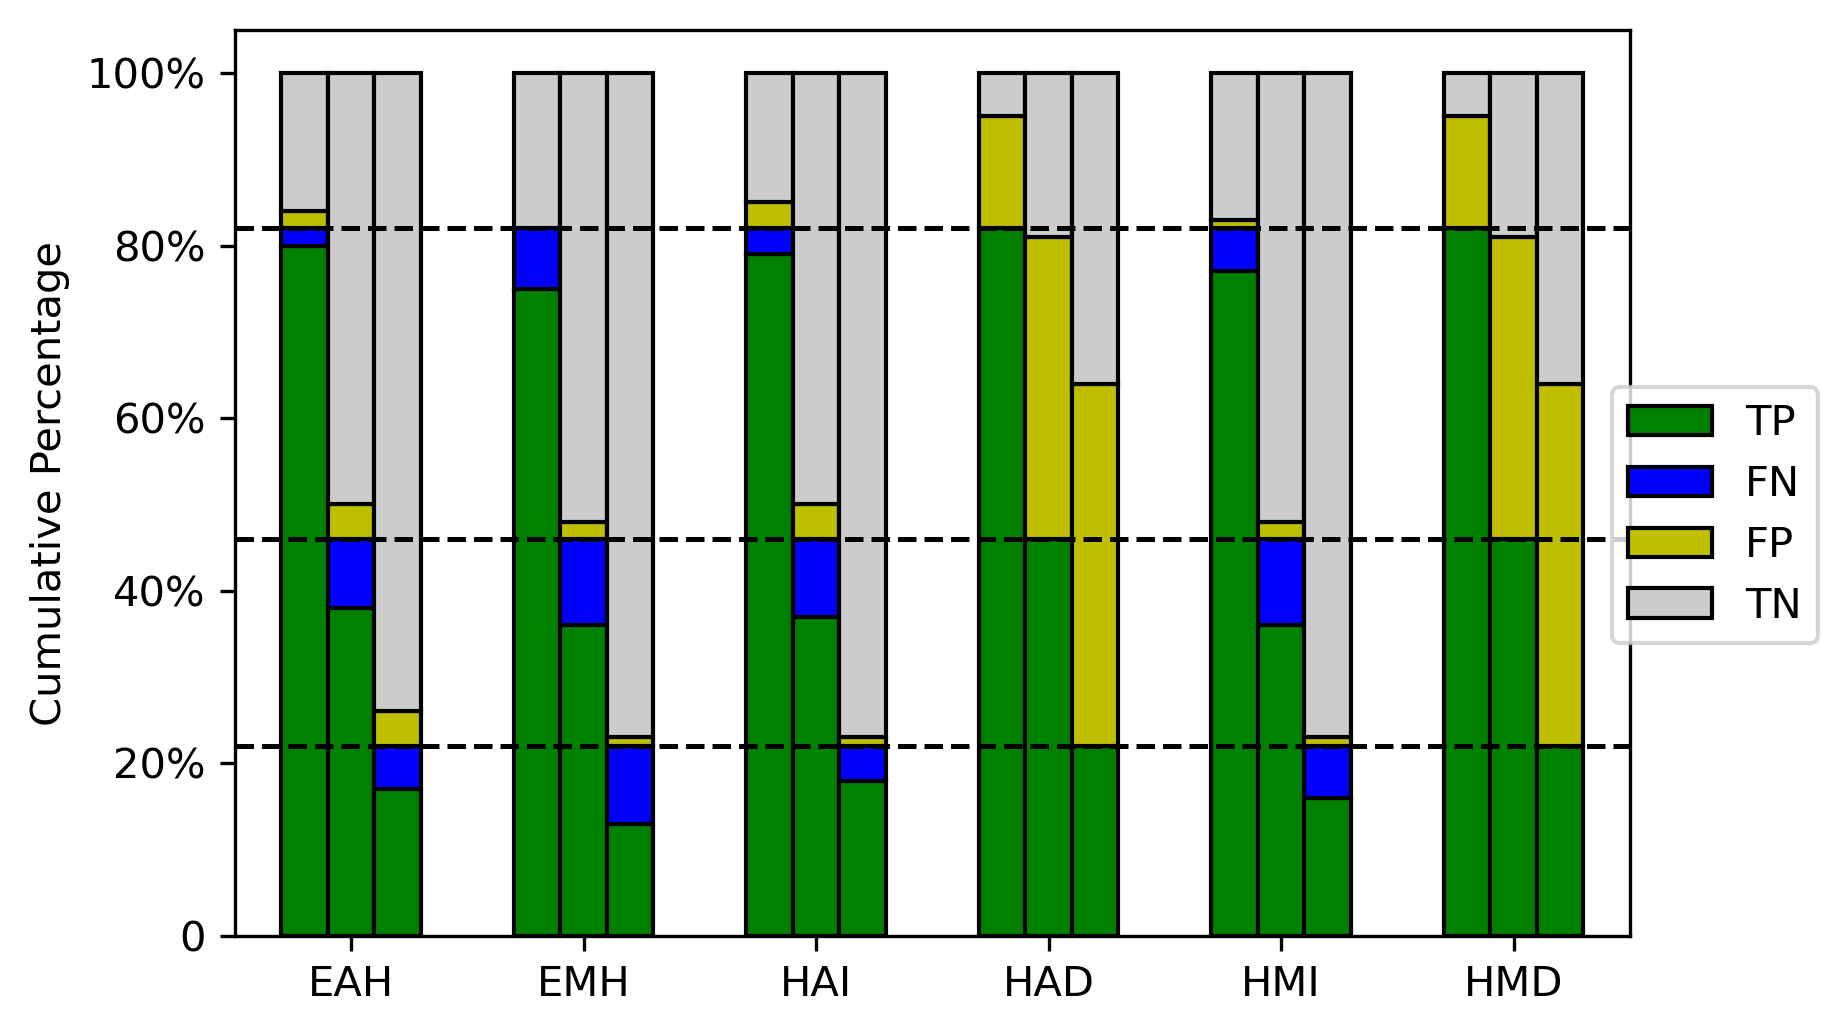

<Figure size 432x288 with 0 Axes>

In [73]:
# Confusion matrix, probability decomposition
x_loc=np.array([1,2,3,4,5,6])
width=0.2
plt.figure(figsize=(6,4),dpi=300)
plt.bar(x_loc-width, P_components[0,:,0],width=width,color='g',linewidth=1,edgecolor='black',label='TP')
plt.bar(x_loc-width, P_components[0,:,1],bottom=P_components[0,:,0],width=width,color='b',linewidth=1,edgecolor='black',label='FN')
plt.bar(x_loc-width, P_components[0,:,2],bottom=P_components[0,:,0]+P_components[0,:,1],width=width,color='y',linewidth=1,edgecolor='black',label='FP')
plt.bar(x_loc-width, 1-P_components[0,:,0]-P_components[0,:,1]-P_components[0,:,2],bottom=P_components[0,:,0]+P_components[0,:,1]+P_components[0,:,2],width=width,color='0.8',linewidth=1,edgecolor='black',label='TN')

plt.bar(x_loc, P_components[1,:,0],width=width,linewidth=1,edgecolor='black',color='g')
plt.bar(x_loc, P_components[1,:,1],bottom=P_components[1,:,0],width=width,linewidth=1,edgecolor='black',color='b')
plt.bar(x_loc, P_components[1,:,2],bottom=P_components[1,:,0]+P_components[1,:,1],width=width,linewidth=1,edgecolor='black',color='y')
plt.bar(x_loc, 1-P_components[1,:,0]-P_components[1,:,1]-P_components[1,:,2],bottom=P_components[1,:,0]+P_components[1,:,1]+P_components[1,:,2],width=width,linewidth=1,edgecolor='black',color='0.8')

plt.bar(x_loc+width, P_components[2,:,0],width=width,linewidth=1,edgecolor='black',color='g')
plt.bar(x_loc+width, P_components[2,:,1],bottom=P_components[2,:,0],width=width,linewidth=1,edgecolor='black',color='b')
plt.bar(x_loc+width, P_components[2,:,2],bottom=P_components[2,:,0]+P_components[2,:,1],width=width,linewidth=1,edgecolor='black',color='y')
plt.bar(x_loc+width, 1-P_components[2,:,0]-P_components[2,:,1]-P_components[2,:,2],bottom=P_components[2,:,0]+P_components[2,:,1]+P_components[2,:,2],width=width,linewidth=1,edgecolor='black',color='0.8')

plt.xticks(x_loc,['EAH','EMH', 'HAI','HAD','HMI','HMD'])
#plt.title('Probability of TP, FP, FN of all estimators under b=0.5, 1.0 and 1.5')
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0','20%','40%','60%','80%','100%'])
plt.hlines([P_components[0,0,0]+P_components[0,0,1],P_components[1,0,0]+P_components[1,0,1],P_components[2,0,0]+P_components[2,0,1]],0.5,6.5, linewidth=1.2,linestyle='dashed',colors='black')
plt.xlim(0.5,6.5)

plt.ylabel('Cumulative Percentage')
plt.legend(loc='lower right',bbox_to_anchor=(1.15, 0.3))#,bbox_to_anchor=(1.18, 0.0))
plt.show()
plt.savefig("COVID Proportion Plot",dpi=300)


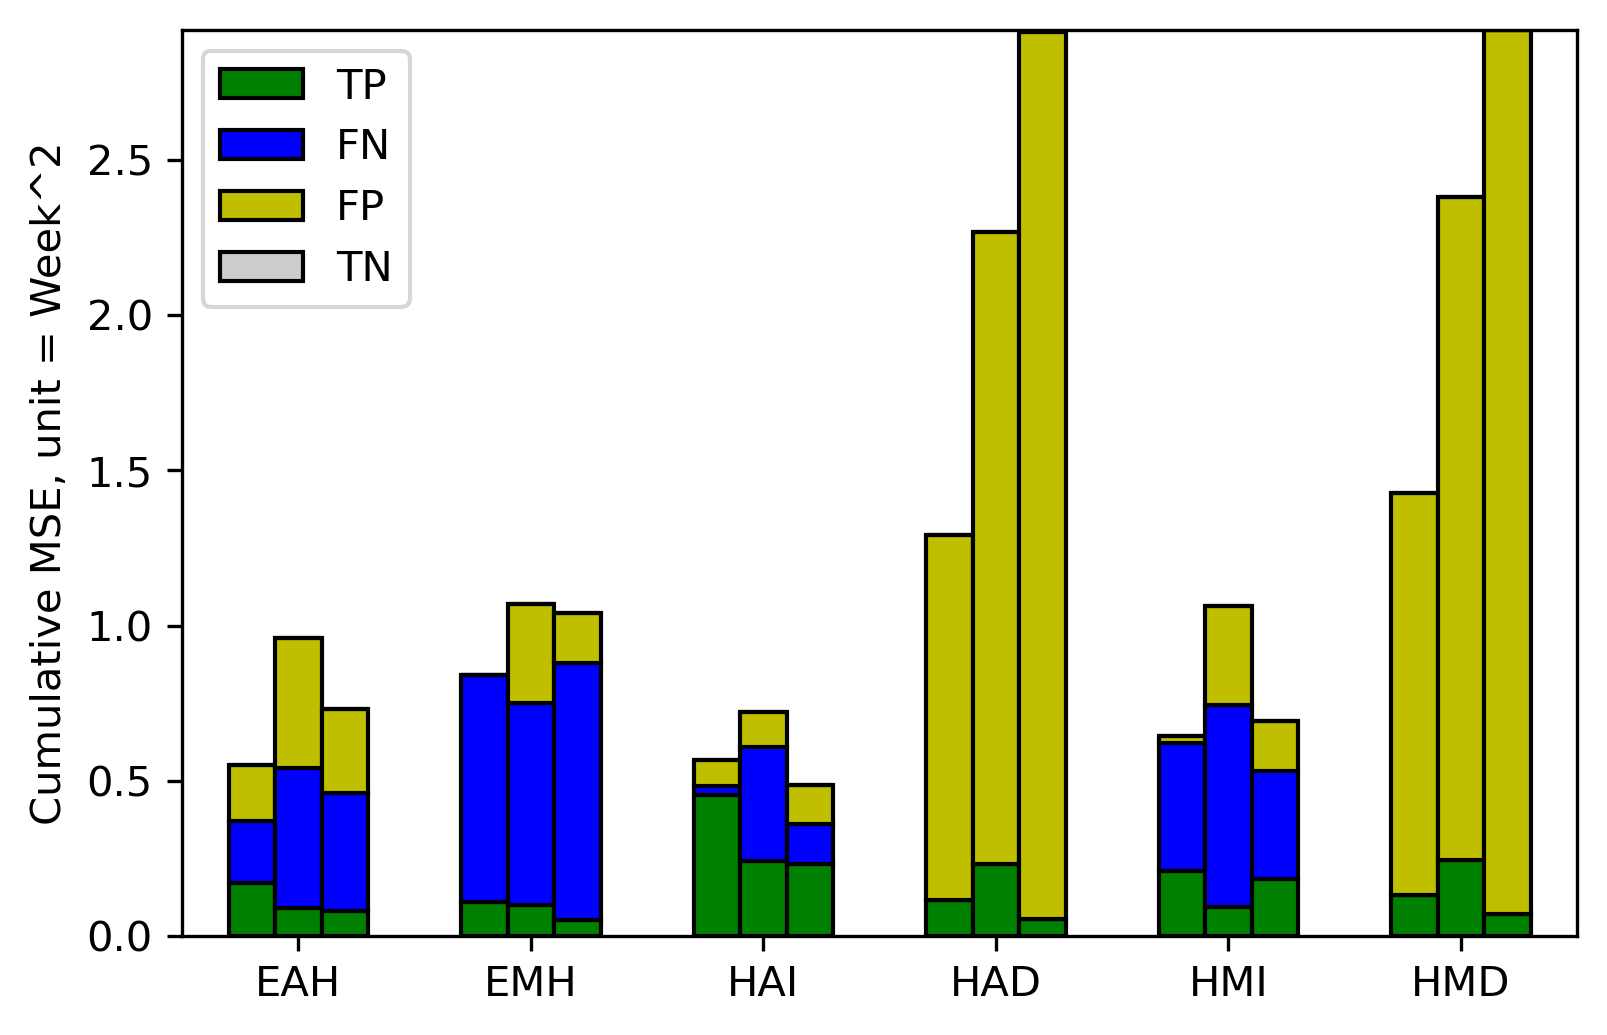

<Figure size 432x288 with 0 Axes>

In [74]:
# Confusion matrix, MSE decomposition

x_loc=np.array([1,2,3,4,5,6])
width=0.2
plt.figure(figsize=(6,4),dpi=300)
P_components = MSE_components

for i in range(3):
    if i == 0:
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,0],width=width,color='g',linewidth=1,edgecolor='black',label='TP')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,1],bottom=MSE_components[i,:,0],width=width,color='b',linewidth=1,edgecolor='black',label='FN')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,2],bottom=MSE_components[i,:,0]+MSE_components[i,:,1],width=width,color='y',linewidth=1,edgecolor='black',label='FP')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,3],bottom=MSE_components[i,:,0]+MSE_components[i,:,1]+MSE_components[i,:,2],width=width,color='0.8',linewidth=1,edgecolor='black',label='TN')
    else:
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,0],width=width,color='g',linewidth=1,edgecolor='black')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,1],bottom=MSE_components[i,:,0],width=width,color='b',linewidth=1,edgecolor='black')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,2],bottom=MSE_components[i,:,0]+MSE_components[i,:,1],width=width,color='y',linewidth=1,edgecolor='black')
        plt.bar(x_loc+width*(i-1), MSE_components[i,:,3],bottom=MSE_components[i,:,0]+MSE_components[i,:,1]+MSE_components[i,:,2],width=width,color='0.8',linewidth=1,edgecolor='black')
plt.xticks(x_loc,['EAH','EMH', 'HAI','HAD','HMI','HMD'])

#plt.title('Probability of TP, FP, FN of all estimators under b=0.5, 1.0 and 1.5')
#plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0','20%','40%','60%','80%','100%'])
#plt.hlines([P_components[i,0,0]+P_components[i,0,1] for i in range(20)],3.5,43.5, linewidth=1.0,linestyle='dashed',colors='black')
plt.xlim(0.5,6.5)

plt.ylabel('Cumulative MSE, unit = Week^2')
plt.legend(loc='upper left')
plt.show()
plt.savefig("COVID MSE Decomposition2.png")


In [77]:
# Example Plotting
model = ['Real', 'BPagano-RtDriven', 'CU-nochange', 'DDS-NBDS',
       'GT-DeepCOVID', 'IEM_MED-CovidProject', 'JBUD-HMXK',
       'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'MIT-Cassandra',
       'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID',
       'MUNI-ARIMA', 'MUNI-VAR', 'Microsoft-DeepSTIA', 'PSI-DRAFT',
       'QJHong-Encounter', 'RobertWalraven-ESG',
       'SteveMcConnell-CovidComplete', 'TTU-squider',
       'UCSD_NEU-DeepGLEAM', 'UMass-MechBayes', 'UMich-RidgeTfReg',
       'USC-SI_kJalpha']
model2 =  ['BPagano-RtDriven', 'CU-nochange', 'DDS-NBDS',
       'GT-DeepCOVID', 'IEM_MED-CovidProject', 'JBUD-HMXK',
       'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'MIT-Cassandra',
       'MIT_CritData-GBCF', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID',
       'MUNI-ARIMA', 'MUNI-VAR', 'Microsoft-DeepSTIA', 'PSI-DRAFT',
       'QJHong-Encounter', 'RobertWalraven-ESG',
       'SteveMcConnell-CovidComplete', 'TTU-squider',
       'UCSD_NEU-DeepGLEAM', 'UMass-MechBayes', 'UMich-RidgeTfReg',
       'USC-SI_kJalpha']
DF1 = pd.DataFrame(index = range(25), columns = ["target_end_date","value","model"])
DF1["model"] = model
DF1["target_end_date"] = [0 for i in range(25)]
DF1["value"] = [8193 for i in range(25)]

In [78]:
DF2 = Data.loc[Data["Start"] == "2021-12-25"][["target_end_date","value","model"]]
DF2.reset_index(drop = True, inplace = True)
DF2.astype({'value':"float"})

a = [1,2,3,4]*25
DF2["target_end_date"] = a
DF2["model"].unique()
DF = pd.concat([DF1,DF2])

In [79]:
p=DF.loc[DF["model"] != "Real"]
n=p.groupby("target_end_date").mean()
#model = w["model"].unique()
#n["value"]


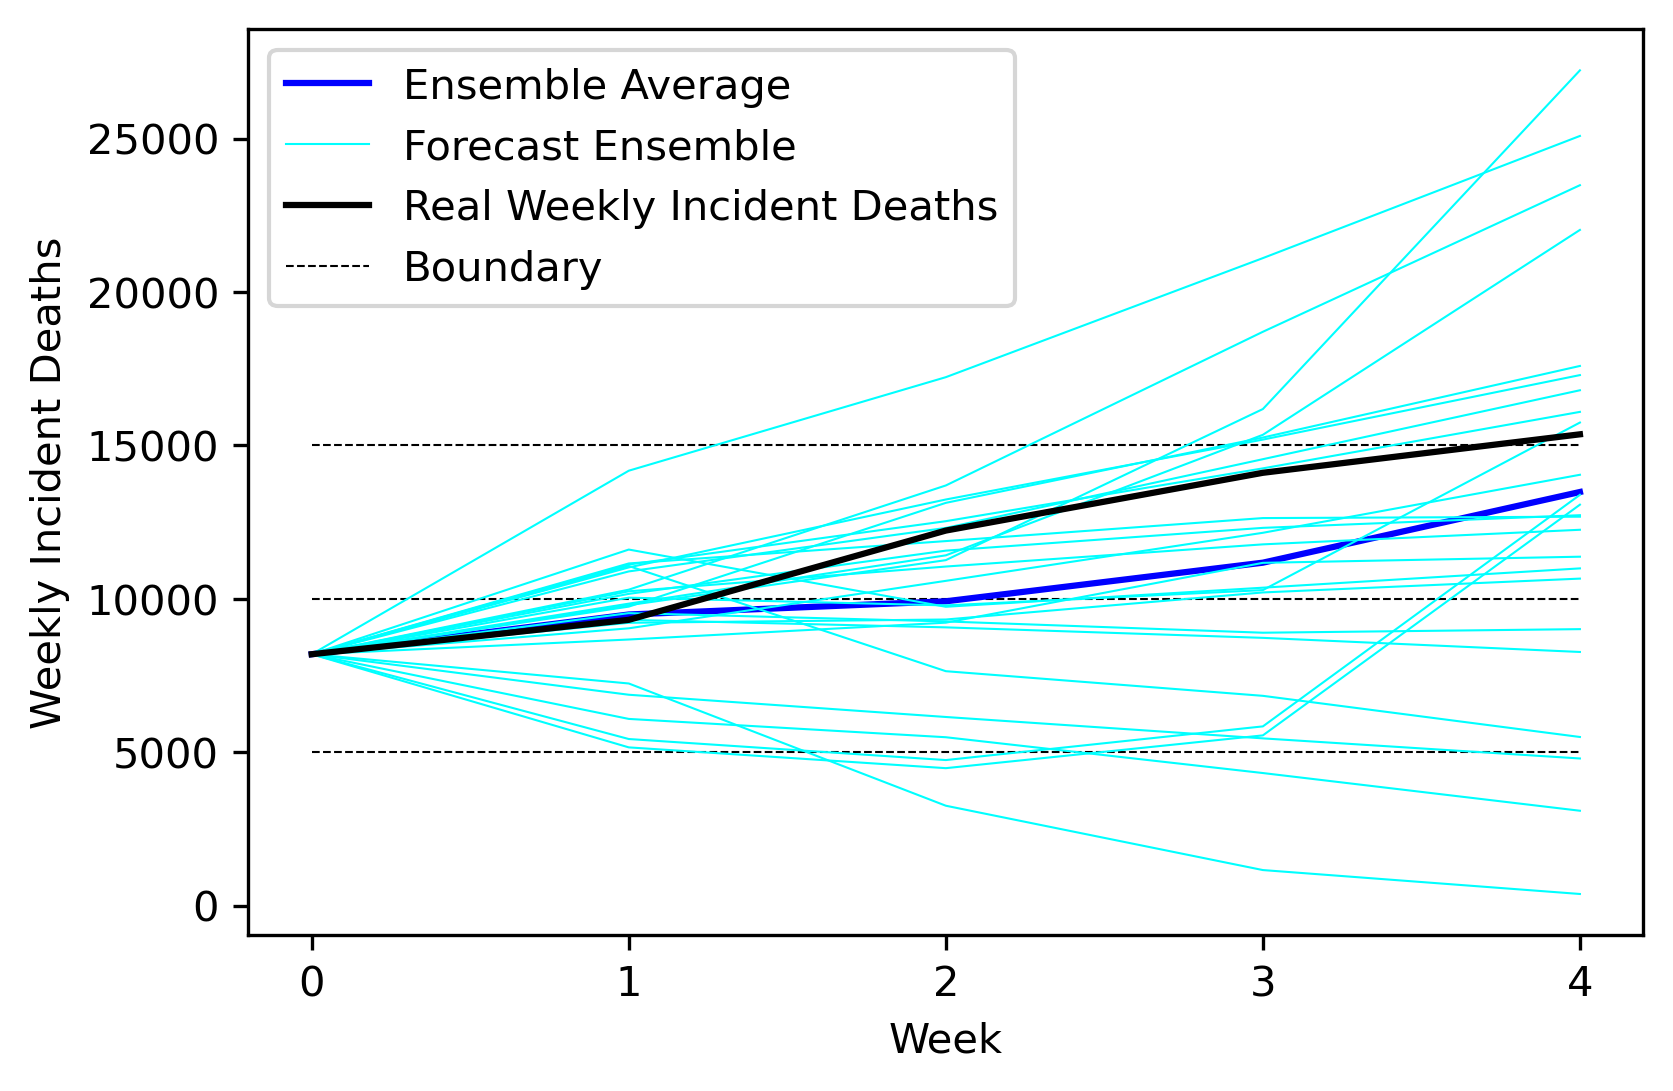

In [81]:

plt.figure(figsize=(6,4),dpi=300)
#sns.lineplot(data =All, x = "target_end_date", y = "value",hue = "model")
#plt.legend(loc="lower left",bbox_to_anchor=(1.0, 0.0))
plt.xticks([0,1,2,3,4])
plt.plot([0,1,2,3,4],n["value"],color='blue',label='Ensemble Average')
for i in model:
    la = DF.loc[DF["model"]==i]
    if i == 'BPagano-RtDriven':
        plt.plot(la["target_end_date"],la["value"],color='aqua',linewidth = 0.5,label='Forecast Ensemble')
    else:
        plt.plot(la["target_end_date"],la["value"],color='aqua',linewidth = 0.5)

    
plt.plot(DF.loc[DF["model"]=="Real"]["target_end_date"],DF.loc[DF["model"]=="Real"]["value"],color='black',label='Real Weekly Incident Deaths')
plt.hlines([5000,10000,15000],0,4,colors='black',linestyles='--',linewidths=0.5,label='Boundary')

#bdry = [9000,11000,13000,15000,17000,10000,12000,14000,16000,18000]

#for i in bdry:
#    plt.axhline(i,ls=":",color = "gray",lw = 0.5)
plt.xlabel('Week')
plt.ylabel('Weekly Incident Deaths')
plt.legend(loc='upper left')#,bbox_to_anchor=(1.18, 0.0))
plt.savefig("COVID Ensemble Plot.png",dpi=300)